본 contents는 페가님의 https://jehyunlee.github.io/2020/03/20/Python-DS-6-plateau_detection/ 내용을 기반으로 필사하였습니다.

<img src="./img/img1.png">

- 물을 끓이는 등 상태가 변할 때, 에너지가 흡수되어 온도가 일정하게 유지가 됩니다. 
- 위와 같은 그래프에서 평평한 영역을 찾고, 각 구간의 대표점을 추출하겠습니다. 
- 데이터 추출과 시각화 과정에서 사용되는 기법은 다음과 같습니다.

__1. Noise Reduction__
- scipy.ndimage :signal averaging, median 
- np.hanning, np.hamming, np.bartlett, np.blackman :smoothing of a 1D signal 
- scipy.signal.savgol_filter : noisy signal smoothing

__2. Clustering__ 

- sklearn.cluster.DBSCAN : unsupervised clustering

__3. Visualization__ 

- r'$ Latex_Expr $'
- matplotlib.axes.Axes.axhline : 수평선 그리기 
- matplotlib.axes.Axes.inset_axes : matplotlib plot에 insert 삽입
- matplotlib.axes.Axes.fill_between : matplotlib plot 중 조건에 맞는 구간 칠하기

# 1. Project Preparation

## 1.1 set up 

In [1]:
import pandas as pd  
import numpy as np 
import scipy as sp 
import sklearn as skl 
import matplotlib as mpl
import seaborn as sns 

## 1.2 Korean Font setting 

In [4]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# mpl.rcParams['axes.unicode_minus'] = False
f_path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)
plt.rcParams["axes.unicode_minus"] = False

## 1.3 Visualization Settings 
- 시각화 전반에 적용할 설정을 세팅합니다.

In [6]:
plt.style.use('seaborn-whitegrid')
sns.set_context("talk")
%matplotlib inline

# 2. Load Data

## 2.1 데이터 파일 읽어오기

- `pandas` 를 이용해 프로젝트의 데이터를 읽어옵니다. 
- 본 페이지에 공개된 데이터는 암호화를 위해 가공된 값으로 실제와 다릅니다.

In [7]:
df = pd.read_csv("./data/6_pld_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       490 non-null    float64
 1   Y       490 non-null    float64
dtypes: float64(2)
memory usage: 7.8 KB


## 2.2. Plot: raw data

- 데이터 확인을 위해 한번 그려봅니다. 

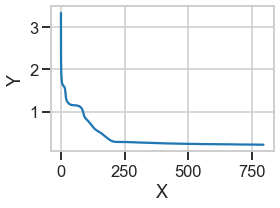

In [8]:
fig, ax = plt.subplots(figsize=[4,3])

ax.plot(df['X'],df['Y'])
ax.set_xlabel('X')
ax.set_ylabel("Y")

plt.tight_layout()

- 실행결과: 선명한 plateau도 있고, 단순한 변곡점으로 보이는 곳도 있습니다. 
- 선명하지 않더라도 꺾이는 지점들은 모두 찾아보겠습니다.

# 3. Plateau Detection

- 변곡점을 포함한 Plateau는 수학적으로 간결하게 정의됩니다. 
- 그러나 실제 데이터는 불연속적이고 1차 미분값이 정확히 0이 될 수 없습니다. 
- tolerance를 지정하여 0에 가까운 지점들을 찾아야 합니다. 

<img src='./img/img2.png'>

## 3.1 1차, 2차, 3차 도함수 계산 

- 미분함수를 구하고 시각화를 해서 전체적인 범위를 파악합니다.

In [30]:
d1 = np.diff(df['Y'])/np.diff(df['X']) # 1st derivative 
d2 = np.diff(d1)/ np.diff(df['X'].iloc[:-1]) # 2nd derivative
d3 = np.diff(d2)/np.diff(df['X'].iloc[:-2]) # 3rd derivative

<ipython-input-30-b196abb7a85c>:1: RuntimeWarning: divide by zero encountered in true_divide
  d1 = np.diff(df['Y'])/np.diff(df['X']) # 1st derivative
C:\Users\sk\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


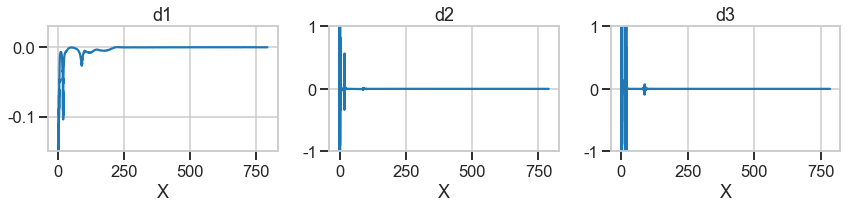

In [31]:
# Visualization 
fig,ax = plt.subplots(ncols=3, figsize=[12,3])
ax[0].plot(df['X'].iloc[:-1],d1)
ax[1].plot(df['X'].iloc[:-2],d2)
ax[2].plot(df['X'].iloc[:-3],d3)

ax[0].set_title("d1")
ax[1].set_title("d2")
ax[2].set_title("d3")

ax[0].set_xlabel("X")
ax[1].set_xlabel("X")
ax[2].set_xlabel("X")

ax[0].set_ylim((-0.15,0.03))
ax[1].set_ylim((-1,1))
ax[2].set_ylim((-1,1))

plt.tight_layout()

- 실행결과: X=0 부근의 변동이 커서 다른 값이 잘 보이지 않습니다. 

- 확대해서 관심 영역을 확인합니다.

## 3.2. 가로축 변환 (X- Y) 

- 그래프 형태가 전반적으로 $Y=X^{-1}$ 형태입니다. 
- 좁은 X에 Y가 넓게 분포해 있는데, 이 부분을 자세히 분석할 필요가 있습니다. 
- 다행히 그래프가 단조감소하니 가로축을 Y로 설정하는 것만으로 바꿔볼 수 있습니다. 

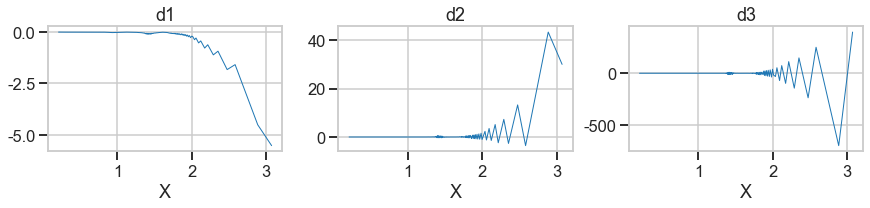

In [32]:
# Visualization 
fig,ax = plt.subplots(ncols=3, figsize=[12,3])
ax[0].plot(df['Y'].iloc[:-1],d1,lw=1)
ax[1].plot(df['Y'].iloc[:-2],d2,lw=1)
ax[2].plot(df['Y'].iloc[:-3],d3,lw=1)

ax[0].set_title("d1")
ax[1].set_title("d2")
ax[2].set_title("d3")

ax[0].set_xlabel("X")
ax[1].set_xlabel("X")
ax[2].set_xlabel("X")

# ax[0].set_xlim((0, 2))
# ax[0].set_ylim((-0.1, 0.02))
# ax[1].set_ylim((-0.1, 0.1))
# ax[2].set_ylim((-0.1, 0.1))

plt.tight_layout()

- 실행결과: 관심영역(세로축 ~0)이 잘 보이지 않습니다. 

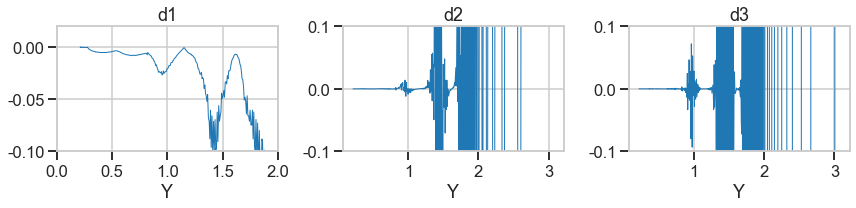

In [33]:
# Visualization 
fig,ax = plt.subplots(ncols=3, figsize=[12,3])
ax[0].plot(df['Y'].iloc[:-1],d1,lw=1)
ax[1].plot(df['Y'].iloc[:-2],d2,lw=1)
ax[2].plot(df['Y'].iloc[:-3],d3,lw=1)

ax[0].set_title("d1")
ax[1].set_title("d2")
ax[2].set_title("d3")

ax[0].set_xlabel("Y")
ax[1].set_xlabel("Y")
ax[2].set_xlabel("Y")

ax[0].set_xlim((0, 2))
ax[0].set_ylim((-0.1, 0.02))
ax[1].set_ylim((-0.1, 0.1))
ax[2].set_ylim((-0.1, 0.1))

plt.tight_layout()

- 실행결과: 데이터에 노이즈가 상당합니다.

## 3.3 Noise Reduction 

- 현재의 데이터로는 미분치의 극값을 구하는 의미가 없습니다. 
- 수학적인 방식으로 plateau detection을 하려면 그래프가 매끈해야 합니다. 

### 3.3.1 Algorithms Test 

#### (1) Average and Median

- `scipy`의 `ndimage` 모듈을 이용합니다. 
- signal 외에도 image를 포함한 n-dimensional data에 적용 가능한 기능입니다.

In [24]:
from scipy import ndimage

def average(raw, box_size):
    box = np.ones(box_size)/box_size
    raw_smooth = np.convolve(box, raw, mode = 'same')
    # 검출 및 분류에서 사용
    return raw_smooth

def median(raw, box_size):
    raw_smooth = ndimage.median_filter(raw,box_size)
    return raw_smooth

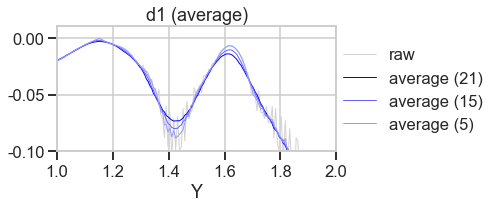

In [25]:
### averaging

d1_avg21 = average(d1, 21)
d1_avg15 = average(d1, 15)
d1_avg05 = average(d1, 5)


fig, ax = plt.subplots(ncols=1, figsize=(7, 3))
ax.plot(df['Y'].iloc[:-1], d1, lw=1, c='lightgray', label='raw')

ax.plot(df['Y'].iloc[:-1], d1_avg21, lw=1, c='#0000FF', label='average (21)')

ax.plot(df['Y'].iloc[:-1], d1_avg15, lw=1, c='#6666FF', label='average (15)')

ax.plot(df['Y'].iloc[:-1], d1_avg05, lw=1, c='#9999FF', label='average (5)')


ax.set_xlim((1, 2))
ax.set_ylim((-0.1, 0.01))

ax.set_title('d1 (average)')
ax.set_xlabel('Y')

plt.legend(loc=[1, 0.1])
plt.tight_layout()

- 실행결과 (`average`) : box_size가 클수록 noise와 함께 다른 데이터도 왜곡이 됩니다.

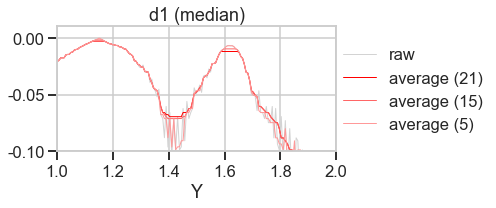

In [44]:
### median

d1_med21 = median(d1,21)
d1_med15 = median(d1,15)
d1_med05 = median(d1,5)

fig,ax = plt.subplots(ncols=1,figsize=[7,3])

ax.plot(df['Y'].iloc[:-1],d1,lw=1,c='lightgray',label='raw')

ax.plot(df['Y'].iloc[:-1],d1_med21,lw=1,c="#FF0000",label='average (21)')

ax.plot(df['Y'].iloc[:-1],d1_med15,lw=1,c="#FF6666",label ='average (15)')

ax.plot(df['Y'].iloc[:-1],d1_med05,lw=1,c="#FF9999",label = "average (5)")


ax.set_xlim((1, 2))
ax.set_ylim((-0.1, 0.01))

ax.set_title('d1 (median)')
ax.set_xlabel('Y')

plt.legend(loc=[1, 0.1])

plt.tight_layout()

#### (2) Numpy smoothing options

- 위 방법은 box 안의 데이터를 모두 동등하게 처리하므로 주변 데이터의 영향이 큽니다. 

- `numpy`의 window function을 이용하면 중심부 데이터에 가중치를 줄 수 있습니다.